In [1]:
import importlib
import os
from joblib import dump, load

import numpy as np
import pandas as pd

import ml.explo as mlexplo
import ml.prepare as mlprepare

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import metrics

data_path = "..\\data\\stackoverflow\\"
model_path = data_path + "models\\"
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = "{:,.2f}".format

In [2]:
y_dict = load(data_path + 'y_dict_top50.joblib')
title_vectorizer = load(model_path + 'title_vectorizer.joblib')
body_vectorizer = load(model_path + 'body_vectorizer_11.joblib')

title_corpus = load(data_path + 'title_corpus.joblib')
X_title = title_vectorizer.fit_transform(title_corpus)

body_corpus = load(data_path + 'body_corpus.joblib')
X_body = body_vectorizer.fit_transform(body_corpus)

In [3]:
y_dict.keys()

dict_keys(['python', 'other', 'javascript', 'r', 'pandas', 'java', 'c++', 'c#', 'python-3.x', 'sql', 'html', 'dataframe', 'reactjs', 'arrays', 'c', 'css', 'regex', 'android', 'php', 'typescript', 'swift', 'node.js', 'mysql', 'angular', 'jquery', 'numpy', 'json', 'list', 'postgresql', 'ios', 'mongodb', 'dplyr', 'django', 'sql-server', 'swiftui', 'string', 'powershell', 'vue.js', 'azure', 'ggplot2', 'flutter', 'bash', 'git', 'excel', 'firebase', 'asp.net-core', 'google-sheets', 'kotlin', 'laravel', 'dictionary', 'oracle'])

In [4]:
body_model = load(model_path + 'top50_body_RidgeC_baseline.joblib')
title_model = load(model_path + 'top50_title_RidgeC_baseline.joblib')

In [42]:
txt = 'help array  df'
tag = 'python'
title_tv = title_vectorizer.transform([txt])
body_tv = body_vectorizer.transform([txt])
print ("Reverse : ", body_vectorizer.inverse_transform(body_tv))
# print ('Should I tag python?', clf.predict(tv))
print ('Title_model:', title_model[tag].predict(title_tv))
print ('Body_model:', body_model[tag].predict(body_tv))
print ('Body_model:', clf.predict(body_tv))



Reverse :  [array(['help', 'df', 'array'], dtype='<U23')]
Title_model: [0]
Body_model: [0]


In [5]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X_body, y_dict['python'], 
#                                                         random_state=42,
                                                        test_size=0.2, shuffle=True)

clf = RandomForestClassifier(n_jobs=6)
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=6)

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
score = clf.predict_proba(X_test)
fpr, tpr, th = roc_curve(y_test, score[:,1])

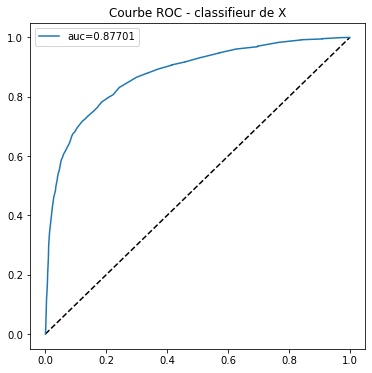

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)
ax.plot(fpr, tpr, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - classifieur de X')
ax.legend();

In [12]:
params = {
    'alpha': np.arange(10)*.1+.05,
    'max_iter': [25],
    'solver': ['sag']

    }

gs_clf = GridSearchCV(
    RidgeClassifier(),
    params,
    n_jobs=6)

for count in (np.arange(10)+1)*5000:
    gs_clf.fit(X_train[:count], y_train[:count])
    print(gs_clf.best_estimator_)
    print(gs_clf.best_estimator_.score(X_test, y_test))

RidgeClassifier(alpha=0.7500000000000001, max_iter=25, solver='sag')
0.8614
RidgeClassifier(alpha=0.8500000000000001, max_iter=25, solver='sag')
0.8668
RidgeClassifier(alpha=0.15000000000000002, max_iter=25, solver='sag')
0.8671
RidgeClassifier(alpha=0.05, max_iter=25, solver='sag')
0.8681
RidgeClassifier(alpha=0.05, max_iter=25, solver='sag')
0.867
RidgeClassifier(alpha=0.25, max_iter=25, solver='sag')
0.8672
RidgeClassifier(alpha=0.05, max_iter=25, solver='sag')
0.8673
RidgeClassifier(alpha=0.35000000000000003, max_iter=25, solver='sag')
0.8675
RidgeClassifier(alpha=0.35000000000000003, max_iter=25, solver='sag')
0.8675
RidgeClassifier(alpha=0.35000000000000003, max_iter=25, solver='sag')
0.8675


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_body, y_dict['python'], random_state=42, test_size=0.2, shuffle=True)
params = {
    'alpha': np.arange(10)*.1+.1,
    'max_iter': [20],
    'solver': ['sag']
    }
clf = GridSearchCV(
    RidgeClassifier(),
    params,
    n_jobs=6)
clf.fit(X_train, y_train)
clf.best_estimator_

RidgeClassifier(alpha=0.5, max_iter=20, solver='sag')

In [30]:
clf.classes_

array([0, 1], dtype=int64)

In [9]:
clf.best_estimator_.score(X_test, y_test)

0.8789

In [9]:
dump(clf.best_estimator_, data_path + 'baseline_python.joblib')

['..\\data\\stackoverflow\\baseline_python.joblib']

[array(['on', 'need', 'help', 'dict'], dtype='<U674')]

In [15]:
params = {
    'alpha': np.arange(10)*.1+.1,
    'max_iter': [25],
    }
clf = GridSearchCV(
    RidgeClassifier(),
    params,
    n_jobs=6)

baseline =  dict({})

for k in y_dict.keys():
    print("classifying:", k)
    X_train, X_test, y_train, y_test = train_test_split(X_body, y_dict[k], random_state=42, test_size=0.2, shuffle=True)
#     X_train, X_test, y_train, y_test = train_test_split(X_title, y_dict[k], random_state=42, test_size=0.2, shuffle=True)
#     clf = RidgeClassifier().fit(X_train, y_train)
    clf = GridSearchCV(
        RidgeClassifier(),
        params,
        n_jobs=6)
    clf.fit(X_train, y_train)
    baseline[k] = clf.best_estimator_
    print("GS best:", clf.best_estimator_)
    print("clf score: ", clf.best_estimator_.score(X_test, y_test))
    pred = clf.best_estimator_.predict(X_test)
    f1 = metrics.f1_score(y_test, pred)
    precision = metrics.precision_score(y_test, pred)
    recall = metrics.recall_score(y_test, pred)
    print("F1:   %0.3f, precision: %0.3f, recall: %0.3f" % (f1, precision, recall))
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))
    print("=========================")
dump(baseline, model_path + 'body_ridgeClassifier.joblib')

classifying: python
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.8703
F1:   0.513, precision: 0.795, recall: 0.379
confusion matrix:
[[8020  176]
 [1121  683]]
classifying: other
GS best: RidgeClassifier(alpha=0.2, max_iter=25)
clf score:  0.8683
F1:   0.171, precision: 0.642, recall: 0.099
confusion matrix:
[[8547   76]
 [1241  136]]
classifying: javascript
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9082
F1:   0.412, precision: 0.768, recall: 0.282
confusion matrix:
[[8760   97]
 [ 821  322]]
classifying: r
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9358
F1:   0.425, precision: 0.772, recall: 0.293
confusion matrix:
[[9121   70]
 [ 572  237]]
classifying: pandas
GS best: RidgeClassifier(alpha=0.2, max_iter=25)
clf score:  0.9623
F1:   0.628, precision: 0.799, recall: 0.517
confusion matrix:
[[9305   80]
 [ 297  318]]
classifying: java
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.951
F1:   0.364, precision: 0.7

C:\Users\vince\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GS best: RidgeClassifier(alpha=0.5, max_iter=25)
clf score:  0.9877
F1:   0.031, precision: 0.667, recall: 0.016
confusion matrix:
[[9875    1]
 [ 122    2]]
classifying: mongodb
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9906
F1:   0.510, precision: 0.875, recall: 0.360
confusion matrix:
[[9857    7]
 [  87   49]]
classifying: dplyr
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9886
F1:   0.000, precision: 0.000, recall: 0.000
confusion matrix:
[[9886    0]
 [ 114    0]]
classifying: django


C:\Users\vince\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9928
F1:   0.625, precision: 0.909, recall: 0.476
confusion matrix:
[[9868    6]
 [  66   60]]
classifying: sql-server
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9878
F1:   0.062, precision: 1.000, recall: 0.032
confusion matrix:
[[9874    0]
 [ 122    4]]
classifying: swiftui
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9924
F1:   0.525, precision: 1.000, recall: 0.356
confusion matrix:
[[9882    0]
 [  76   42]]
classifying: string
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9888
F1:   0.000, precision: 0.000, recall: 0.000
confusion matrix:
[[9888    0]
 [ 112    0]]
classifying: powershell


C:\Users\vince\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9932
F1:   0.534, precision: 0.975, recall: 0.368
confusion matrix:
[[9893    1]
 [  67   39]]
classifying: vue.js
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9919
F1:   0.532, precision: 0.958, recall: 0.368
confusion matrix:
[[9873    2]
 [  79   46]]
classifying: azure
GS best: RidgeClassifier(alpha=0.5, max_iter=25)
clf score:  0.9922
F1:   0.512, precision: 0.759, recall: 0.387
confusion matrix:
[[9881   13]
 [  65   41]]
classifying: ggplot2
GS best: RidgeClassifier(max_iter=25)
clf score:  0.991
F1:   0.167, precision: 0.562, recall: 0.098
confusion matrix:
[[9901    7]
 [  83    9]]
classifying: flutter
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.9942
F1:   0.525, precision: 0.970, recall: 0.360
confusion matrix:
[[9910    1]
 [  57   32]]
classifying: bash
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.991
F1:   0.416, precision: 0.667, recall: 0.302
confusion m

C:\Users\vince\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GS best: RidgeClassifier(alpha=0.2, max_iter=25)
clf score:  0.994
F1:   0.500, precision: 0.682, recall: 0.395
confusion matrix:
[[9910   14]
 [  46   30]]
classifying: oracle
GS best: RidgeClassifier(alpha=0.1, max_iter=25)
clf score:  0.992
F1:   0.000, precision: 0.000, recall: 0.000
confusion matrix:
[[9920    0]
 [  80    0]]


C:\Users\vince\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['..\\data\\stackoverflow\\models\\body_ridgeClassifier.joblib']

In [16]:
params = {
    'alpha': np.arange(10)*.1+.1,
    'max_iter': [25],
    }
clf = GridSearchCV(
    RidgeClassifier(),
    params,
    n_jobs=6)

baseline =  dict({})

for k in y_dict.keys():
    print("classifying:", k)
    X_train, X_test, y_train, y_test = train_test_split(X_title, y_dict[k], random_state=42, test_size=0.2, shuffle=True)
#     X_train, X_test, y_train, y_test = train_test_split(X_title, y_dict[k], random_state=42, test_size=0.2, shuffle=True)
#     clf = RidgeClassifier().fit(X_train, y_train)
    clf = GridSearchCV(
        RidgeClassifier(),
        params,
        n_jobs=6)
    clf.fit(X_train, y_train)
    baseline[k] = clf.best_estimator_
    print("GS best:", clf.best_estimator_)
    print("clf score: ", clf.best_estimator_.score(X_test, y_test))
    pred = clf.best_estimator_.predict(X_test)
    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))
    print("=========================")
dump(baseline, model_path + 'title_ridgeClassifier.joblib')

classifying: python
GS best: RidgeClassifier(alpha=0.6, max_iter=25)
clf score:  0.9074
accuracy:   0.907
confusion matrix:
[[8002  194]
 [ 732 1072]]
classifying: other
GS best: RidgeClassifier(max_iter=25)
clf score:  0.8905
accuracy:   0.890
confusion matrix:
[[8467  156]
 [ 939  438]]
classifying: javascript
GS best: RidgeClassifier(alpha=0.7000000000000001, max_iter=25)
clf score:  0.9171
accuracy:   0.917
confusion matrix:
[[8705  152]
 [ 677  466]]
classifying: r
GS best: RidgeClassifier(alpha=0.4, max_iter=25)
clf score:  0.9507
accuracy:   0.951
confusion matrix:
[[9147   44]
 [ 449  360]]
classifying: pandas
GS best: RidgeClassifier(alpha=0.7000000000000001, max_iter=25)
clf score:  0.9755
accuracy:   0.976
confusion matrix:
[[9359   26]
 [ 219  396]]
classifying: java
GS best: RidgeClassifier(alpha=0.4, max_iter=25)
clf score:  0.9612
accuracy:   0.961
confusion matrix:
[[9368   51]
 [ 337  244]]
classifying: c++
GS best: RidgeClassifier(alpha=0.4, max_iter=25)
clf score:  0

['..\\data\\stackoverflow\\models\\title_ridgeClassifier.joblib']

In [27]:
title_vectorizer = TfidfVectorizer(ngram_range=(1,1))
body_vectorizer = TfidfVectorizer(ngram_range=(1,1))
# vectorizer = TfidfVectorizer(ngram_range=(2,2))
X_title = title_vectorizer.fit_transform(corpus_title)
X_body = body_vectorizer.fit_transform(corpus_body)
print(vectorizer.get_feature_names())
print(X_title.toarray().shape)

['assign', 'atom', 'base', 'caus', 'code', 'cradl', 'cran', 'date', 'declar', 'domnodeinsert', 'element', 'expand', 'faster', 'filter', 'fix', 'flicker', 'function', 'get', 'hoist', 'import', 'input', 'insid', 'issu', 'jqueri', 'name', 'newton', 'packag', 'panda', 'put', 'python3', 'react', 'return', 'row', 'select', 'specif', 'sql', 'statement', 'subqueri', 'troubl', 'type', 'use', 'valu', 'vector', 'work', 'wrap']
(100, 382)


In [30]:
clf = RidgeClassifier().fit(X_title, y_dict['javascript'])

In [33]:
clf.score(X_title, y_dict['javascript'])

1.0

In [26]:
df = df_only.copy(deep=True)
corpus_title = [' '.join(map(str, w)) for w in df['Title'].tolist()]
corpus_body = [' '.join(map(str, w)) for w in df['Body'].tolist()]
corpus_tags = [' '.join(map(str, w)) for w in df['Tags'].tolist()]

In [48]:
set(corpus_title)[:50]

NameError: name 'corpus_title' is not defined